<center><b>Local Search - GSAT</b></center><br>
Finding solution to the SAT (Boolean Satisfiability Problem or Propositional Satisfiability Problem) using Local Search.

The code below reads in a "problem" file which contains a set of clauses connected by 'AND' logic gates. Each clause can have multiple variables, they are connected by 'OR' logic gates.
After that, it will attempt to find value for each variable by changing only 1 variable in each Step in a hope that it will satisfy all clauses.
The issue with Local Search is that in can get stuck in 'Local Optima' to get around this the system will try multiple restarts each with random initial solutions.

In [1]:
# Imports
import numpy as np
import random
import copy
import sys
import os
import matplotlib.pyplot as plt
from sympy import *
from sympy.plotting import plot, plot_parametric

%matplotlib inline

In [2]:
def GetCharForInt(v):
    """
    Turns an int into a letter of the alphabet. An int that is larger than 26
    will still be turned into a letter in the alphabet but gets an
    index number e.g.: 'c2'
    """
    letter = v % 26
    index = int(v / 26)
    if index > 0:
        return (chr(letter + 97) + str(index))
    else:
        return chr(letter + 97)
    pass

In [3]:
DEBUG = True
DEBUG_LOG = False

def DebugPrint(log):
    if DEBUG_LOG:
        print(log)

class SatProblemSolver():
    """
    SAT problem solver using Local Search
    On init a problem file is loaded in and the clauses are read.
    Call SolveSATProblem to solve the problem 
    """
    def __init__(self, problemFilename):
        self.F = None # current solution
        self.CurrentCost = sys.maxsize # the cost associated with the current solution
        
        # clause tracking
        self.numberOfVars    = 0    # the number of different literals
        self.numberOfClauses = 0    # the number of clauses to satisfy
        self.clauses         = None # the actual clauses to satisfy
        self.clauseValues    = None # tracks the number of variables currently satisfying each clause 0 - 3
        
        # this dictionary is used to track each variable and the clauses they affect
        # it's a tuple (clauseIndex = index of clause it is in), (varSign = is the literal positive or negative)
        self.literalTracker = {}
        
        # stats
        self.TotalCosts = []      # used for tracking stats for each iteration
        self.SolvedInNumSteps = 0 # used for stats for calculating average
        self.SolvedInNumTries = 0 # used for stats for calculating average
        
        self.loadProblemData(problemFilename)
        pass
        
    def loadProblemData(self, problemFilename):
        """
        Loads in the problem file. It requires the file to be setup
        in a very specific way.
        """
        file = open(problemFilename, 'r')
        if file == None:
            print('ERROR - File not found: {}'.format(problemFilename))
            return
        
        # extracting data from the file
        foundProblemLine = False
        clauseIndex = 0
        for line in file:
            words = line.split()
            if not foundProblemLine:
                # the line starting with 'p' contains information about the problem
                if words[0] == 'p':
                    self.numberOfVars = int(words[2])
                    self.numberOfClauses = int(words[3])
                    self.clauses = [None] * self.numberOfClauses
                    self.clauseValues = np.zeros(self.numberOfClauses, dtype=int)

                    foundProblemLine = True
            # the line starting with '%' indicates that there are no more clauses 
            elif words[0] == '%':
                break
            else:
                # after the line that starts with 'p' each line contains a clause
                # I also transform the literals to start from 0 instead of 1 to make things simpler later
                allLiterals = []
                for w in words:
                    if w != '0':
                        literal = int(w)
                        varBool = literal > 0
                        varIndex = abs(literal) - 1 # changing vars to start from 0 here

                        allLiterals.append((varIndex, varBool))
                
                        # add tracking for this variable so we know all variables which clauses they can modify
                        if self.literalTracker.get(varIndex, False) == False:
                            self.literalTracker[varIndex] = []

                        self.literalTracker[varIndex].append((clauseIndex, varBool))

                self.clauses[clauseIndex] = allLiterals
                clauseIndex += 1

        DebugPrint('Loaded problem with {} variables and {} clauses'.format(self.numberOfVars, self.numberOfClauses))       
        pass
    
    def PrintProblem(self):
        """
        Prints the SAT problem clauses in a C++ style formatting
        """
        line = ""
        for i in range(len(self.clauses)):
            line += '('
            loop = 0
            for varIndex, varBool in self.clauses[i]:
                if varBool == False:
                    line += '!'
                line += GetCharForInt(varIndex)
                if loop < len(self.clauses[i])-1:
                    line += ' || '
                loop += 1
            line += ')'
            if i < len(self.clauses)-1:
                line += ' && '
        print(line)
        pass

    def DEBUG_GetCurrentCost(self):
        """
        DEBUG ONLY. Used to check the current cost of the solution
        """
        # loop through each clause and count up the ones that are currently unsatisfied
        fitness = 0
        for clause in self.clauses:
            clauseSatisfied = False
            for varIndex, varBool in clause:
                if self.F[varIndex] == varBool:
                    clauseSatisfied = True
                    break
            if clauseSatisfied == False:
                fitness += 1

        return fitness
    
    def DEBUG_SanityCheckSolution(self):
        """
        DEBUG ONLY. Used to if all clauses are satisfied in the current solution
        """
        # loop through each clause and make sure at least 1 variable is true
        for clause in self.clauses:
            clauseSatisfied = False
            for varIndex, varBool in clause:
                if self.F[varIndex] == varBool:
                    clauseSatisfied = True
                    break
            if clauseSatisfied == False:
                return False

        return True
    
    def FlipVariable(self, flippedIndex, costOfFlip):
        """
        Flips a variable in the current solution. It also adds the passed in cost
        to the current cost fitness of the algorithm
        """

        # grab indices of clauses this variable is in.
        # This is a tuple. Contains the clause index and weather this var in that clause
        # should be true or false
        affectedClauses = self.literalTracker[flippedIndex]
        for clauseIndex, varSign in affectedClauses:
            # check how many of the variables are currently satisfied in this clause
            currentClauseVal = self.clauseValues[clauseIndex]

            # check how many variables will be satisfied in this clause after the flip
            # this is done by checking if this variable previously was true in this clause
            # if it was true before, we know flipping it will make it false and vice a versa
            newClauseVal = currentClauseVal
            if varSign == self.F[flippedIndex]:
                newClauseVal -= 1
                if DEBUG and newClauseVal < 0:
                    print('ERROR: clause {}-s value is below 0 ({})'.format(clauseIndex, newClauseVal))
            else:
                newClauseVal += 1
                if DEBUG and newClauseVal > len(self.clauses[clauseIndex]):
                    print('ERROR: clause {}-s value is greater({}) than number of variables in the clause ({})'.format(clauseIndex, newClauseVal, len(self.clauseValues[clauseIndex])))

            # update the clause's value
            self.clauseValues[clauseIndex] = newClauseVal

        # actually do the flipping of the variable in the solution
        self.F[flippedIndex] = not self.F[flippedIndex]
        # update the cost, we rely on the calling function telling us how much
        # the flipping will change the total cost. This is so we don't have to recalculate it here
        self.CurrentCost += costOfFlip
        
        # update stats
        self.TotalCosts.append(self.CurrentCost)

        # debug only code used to track down issue caused by incorrect variable flipping cost calculations
        if DEBUG:
            diff = self.CurrentCost - self.DEBUG_GetCurrentCost()
            if diff != 0:
                print('==================ERROR================')
                print('Flipping {} resulted in a larger change than expected: {}. Should have been: {}'.format(flippedIndex, diff, costOfFlip))
        pass
                
    def GetCostOfVarFlip(self, F, flippedIndex):
        """
        Calculates how would flipping a variable would affect the cost
        This is the net cost
        """
        addedCost = 0
        # grab indices of clauses this variable is in.
        # This is a tuple. Contains the clause index and weather this var in that clause
        # should be true or false
        affectedClauses = self.literalTracker[flippedIndex]
        for clauseIndex, varSign in affectedClauses:
            # check how many of the variables are currently satisfied in this clause
            currentClauseVal = self.clauseValues[clauseIndex]
            
            # check how many variables will be satisfied in this clause after the flip
            # this is done by checking if this variable previously was true in this clause
            # if it was true before, we know flipping it will make it false and vice a versa
            newClauseVal = currentClauseVal
            if varSign == F[flippedIndex]:
                newClauseVal -= 1
            else:
                newClauseVal += 1

            #if previously it was solved
            if currentClauseVal > 0:
                #if now it's NOT solved anymore
                if newClauseVal <= 0:
                    addedCost += 1
            #if previously it was NOT solved
            else:
                #if now it is solved
                if newClauseVal > 0:
                    addedCost -= 1
        
        return addedCost
        
    def GetClauseValue(self, clause):
        """
        Returns how many literals in a clause are satisfied
        For 3SAT this can be 0 to 3.
        """
        # loops through each variable in a clause and adds up how many are true
        counter = 0
        for varIndex, varBool in clause:
            if self.F[varIndex] == varBool:
                counter += 1

        return counter
    
    def CalculateInitialCost(self):
        """
        Calculates the initial cost of the passed in solution
        """
        initialCost = 0
        # loop through each clause
        for i in range(self.numberOfClauses):
            # get the number of literals satisfied in this clause
            clauseVal = self.GetClauseValue(self.clauses[i])
            
            # cache the start value of this clause
            # after this we will only update this value, won't check again
            self.clauseValues[i] = clauseVal
            
            # if 0 literals are satisfied in this clause count up the cost
            if clauseVal <= 0:
                initialCost += 1

        DebugPrint('Initial Cost: {}'.format(initialCost))
        return initialCost
    
    def CreateInitialSolution(self):
        """
        Randomly assigns True or False to the solution variables
        """
        # randomly assign a True or False to each variable
        # TODO TO OPTIMISE THIS: Use a heuristic method to assign initial values
        # Checking how many clauses use the value "as is" or use it as "not the value" would
        # tell us the ideal initial value for each variable
        self.F = [False] * self.numberOfVars
        for i in range(self.numberOfVars):
            if random.random() < 0.5:
                self.F[i] = True
        
        # calculate the initial cost and cache it
        self.CurrentCost = self.CalculateInitialCost()
        self.TotalCosts.append(self.CurrentCost) # add current cost to tracker
        pass
    
    def SolveSATProblem(self, maxTries, maxSteps):
        """
        Tries to solve the SAT problem. It can stuck in local optima that is why restarts are required
        maxTries - is the maximum number of times the algorithm will restart
        maxSteps - the maximum number of times the algorithm will try to improve its current solution
        """
        self.F = None
        self.TotalCosts = [] # used for graph
        
        # loop for a number of times if no solution is found
        for t in range(maxTries):
            self.CreateInitialSolution()
            
            if self.CurrentCost == 0:
                self.SolvedInNumTries = t
                self.SolvedInNumSteps = s
                print('Initial solution solved it in restart:{}'.format(t))
                return self.F
            
            # loop for a set number of times to try to improve initial solution
            for s in range(maxSteps):
                # go through each variable and flip it, check how it would affect the score 
                flippedStateCost = np.zeros(self.numberOfVars, dtype=int)
                for v in range(self.numberOfVars):
                    # 0 means no change '-' values would decrease cost, '+' values would increase cost
                    costOfFlipping = self.GetCostOfVarFlip(self.F, v)
                    flippedStateCost[v] = costOfFlipping
                
                # when all variable changes have their cost value lets find the best
                flippedCostOrders = np.argsort(flippedStateCost)
                bestFlippedIndex  = flippedCostOrders[0]
                bestFlippedCost   = flippedStateCost[bestFlippedIndex]
                
                # how many best scores we have? If there are multiple, pick one randomly
                numberOfTies = np.count_nonzero(flippedStateCost == bestFlippedCost)
                bestFlippedIndex = random.randrange(0, numberOfTies)
                variableIndexToFlip = flippedCostOrders[bestFlippedIndex]
                
                # actually flip the variable in the current result
                self.FlipVariable(variableIndexToFlip, bestFlippedCost)
                
                if self.CurrentCost < 0:
                    print('ERROR! Negative cost! It should not be possible. Cost: {}'.format(currentCost))
                
                # if total cost is 0, we have a solution
                if self.CurrentCost == 0:
                    self.SolvedInNumTries = t # update stats
                    self.SolvedInNumSteps = s # update stats
                    print('Solved in try {}, step: {}'.format(t, s))
                    return self.F
                
        return None


In [4]:
maxTries = 50 # number of times the algorithm will reset and try again if needed
maxSteps = 50 # number of times each try will try to improve the solution

path = 'data/SATdata/Inst/'
problemFiles = os.listdir(path)

Solving first SAT problem(uf20-01.cnf) with maxTries: 50 and maxSteps: 50
SAT problem to solve:
(d || !r || s) && (c || r || !e) && (!e || !h || !o) && (!t || g || !p) && (j || !m || !g) && (!l || !i || q) && (q || s || e) && (!p || i || o) && (k || !e || !n) && (r || !j || m) && (!c || k || l) && (!f || !q || !h) && (!r || n || a) && (!s || !o || j) && (l || r || !s) && (!h || d || g) && (!h || !i || d) && (g || q || !o) && (l || !g || !n) && (!j || !k || h) && (b || !o || !k) && (i || f || a) && (!k || t || !q) && (i || !o || m) && (l || !g || !q) && (!r || !b || t) && (t || l || d) && (s || k || n) && (!p || r || !d) && (!a || !q || !s) && (!m || o || j) && (!l || !n || !m) && (l || !n || !g) && (!g || p || j) && (f || j || g) && (t || n || !p) && (!s || q || k) && (!g || a || !t) && (!e || l || o) && (!d || !i || !m) && (l || !k || !g) && (!e || s || !h) && (a || p || q) && (t || !n || !o) && (m || !d || j) && (n || g || j) && (!e || i || t) && (j || a || !s) && (!p || !o || !a) &&

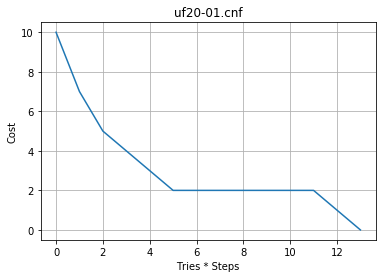

In [5]:
# Solving the first problem with extra details

problemFile  = path + problemFiles[0]
print('Solving first SAT problem({}) with maxTries: {} and maxSteps: {}'.format(problemFiles[0], maxTries, maxSteps))
solver = SatProblemSolver(problemFile)
print('SAT problem to solve:')
solver.PrintProblem()
solution = solver.SolveSATProblem(maxTries, maxSteps)

print('SAT solution is:')
if solution != None:
    if DEBUG:
        solver.DEBUG_SanityCheckSolution()
    
    for v in range(solver.numberOfVars):
        res = 'false'
        if solution[v]:
            res = 'true'
        print('bool {} = {};'.format(GetCharForInt(v), res))
else:
    print('Could NOT solve problem')
    
fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title(problemFiles[0])
axes.set_ylabel('Cost')
axes.set_xlabel('Tries * Steps')
axes.grid()
axes.plot(solver.TotalCosts)


Trying to solve problem: uf20-01.cnf in maxTries: 50, maxSteps: 50
Solved in try 0, step: 44
Solution is: [True, False, False, True, False, False, False, True, False, True, False, False, True, True, True, False, True, False, False, True]

Trying to solve problem: uf20-02.cnf in maxTries: 50, maxSteps: 50
Solved in try 0, step: 13
Solution is: [False, False, False, False, True, False, True, True, True, False, False, False, False, True, False, True, False, False, True, False]

Trying to solve problem: uf20-03.cnf in maxTries: 50, maxSteps: 50
Solved in try 3, step: 44
Solution is: [True, True, True, True, False, True, True, True, True, True, True, False, True, False, False, True, True, True, False, True]

Trying to solve problem: uf20-04.cnf in maxTries: 50, maxSteps: 50
Solved in try 3, step: 4
Solution is: [True, False, True, True, False, False, False, False, False, True, False, False, True, False, False, True, True, False, False, False]

Trying to solve problem: uf20-05.cnf in maxTrie

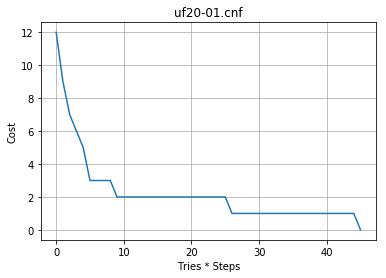

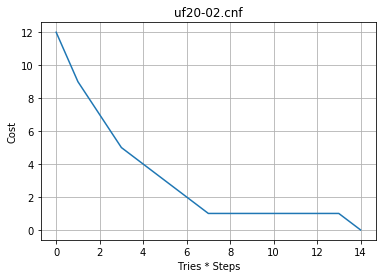

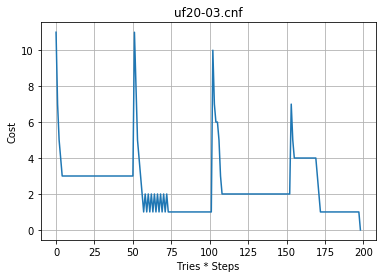

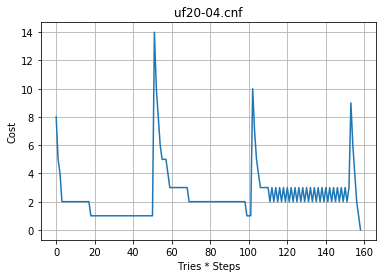

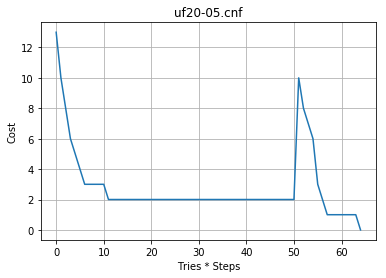

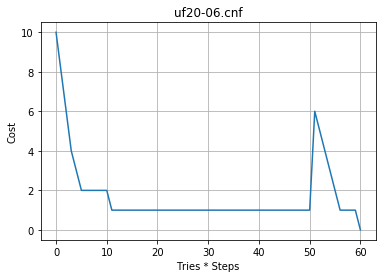

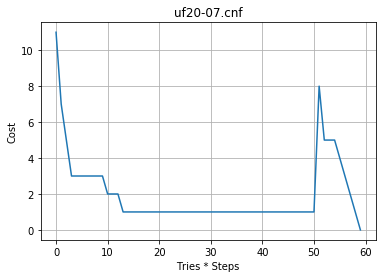

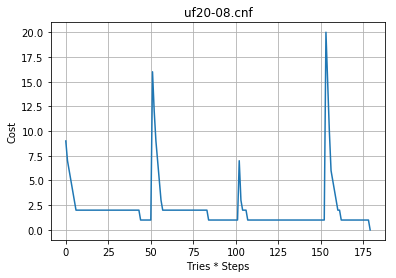

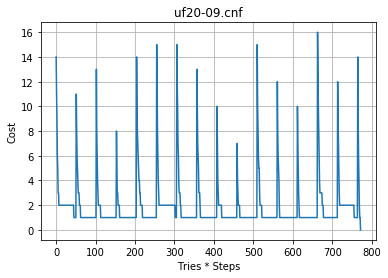

In [6]:
# Solving all SAT problems

solvedProblemsCounter = 0
solvedInTriesAverage = 0
solvedInStepsAverage = 0
for problem in problemFiles:
    problemFile  = path + problem

    print('Trying to solve problem: {} in maxTries: {}, maxSteps: {}'.format(problem, maxTries, maxSteps))
    solver = SatProblemSolver(problemFile)
    solution = solver.SolveSATProblem(maxTries, maxSteps)
    if solution != None:
        if DEBUG:
            solver.DEBUG_SanityCheckSolution()

        solvedProblemsCounter += 1
        solvedInTriesAverage += solver.SolvedInNumTries
        solvedInStepsAverage += solver.SolvedInNumSteps
    
    print('Solution is: {}'.format(solution))
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title(problem)
    axes.set_ylabel('Cost')
    axes.set_xlabel('Tries * Steps')
    axes.grid()
    axes.plot(solver.TotalCosts)
    print('')
    
print('Solved {} out of {}'.format(solvedProblemsCounter, len(problemFiles)))
solvedInTriesAverage = solvedInTriesAverage / solvedProblemsCounter
solvedInStepsAverage = solvedInStepsAverage / solvedProblemsCounter
print('On Average solved in {} tries and {} steps'.format(round(solvedInTriesAverage,2), round(solvedInStepsAverage,2)))
